In [1]:
import sys
sys.path.insert(1, '../../')
from utils import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import butter, sosfiltfilt, find_peaks

def break_correct(data):
    corrected_data = np.copy(data)
    for i in range(1, len(data)):
        diff = data[i] - data[i - 1]
        if diff < -180:  # Assuming a break from 360 to 0
            corrected_data[i:] += 360
        elif diff > 180:  # Assuming a break from 0 to 360
            corrected_data[i:] -= 360
    return corrected_data

def signal_filter(data, fc1, fc2, fs, order=3):
    sos = butter(order, fc1, btype='high', fs=fs, analog=False, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    sos = butter(order, fc2, btype='low', fs=fs, analog=False, output='sos')
    filtered_data = sosfiltfilt(sos, filtered_data)
    return filtered_data

In [2]:
file_path = '../../dataset/basketball/test-2024-01-10-16-01-28.csv'
data = pd.read_csv(file_path).to_numpy()
timestamps = (data[:, 0] - data[0, 0])/ 1000
timestamps = np.linspace(0, timestamps[-1], len(timestamps))
c = data[:, 1]
b = data[:, 2]
tl = data[:, 3]
tr = data[:, 4]
r = data[:, 5]
p = data[:, 6]
y = data[:, 7]

y = break_correct(y)

In [3]:
_, c = upsample(timestamps, c, 100)
_, b = upsample(timestamps, b, 100)
_, tl = upsample(timestamps, tl, 100)
_, tr = upsample(timestamps, tr, 100)
_, y = upsample(timestamps, y, 100)
_, p = upsample(timestamps, p, 100)
_, r = upsample(timestamps, r, 100)
timestamps, _ = upsample(timestamps, timestamps, 100)

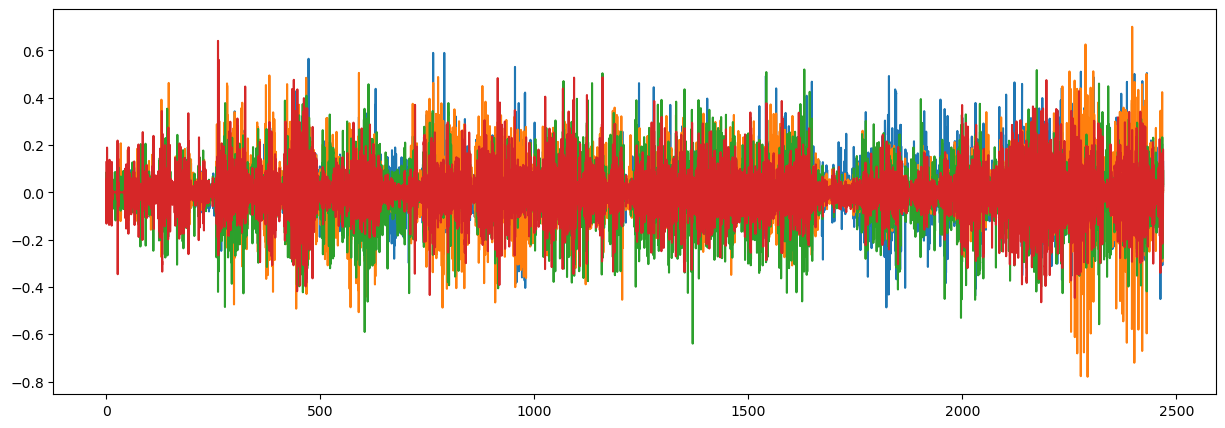

In [4]:
c = signal_filter(c, 0.4, 8, 1000)
b = signal_filter(b, 0.4, 8, 1000)
tl = signal_filter(tl, 0.4, 8, 1000)
tr = signal_filter(tr, 0.4, 8, 1000)

plt.figure(figsize=(15, 5))
plt.plot(timestamps, c)
plt.plot(timestamps, b)
plt.plot(timestamps, tl)
plt.plot(timestamps, tr)

# plt.xlim(480, 510)
plt.show()

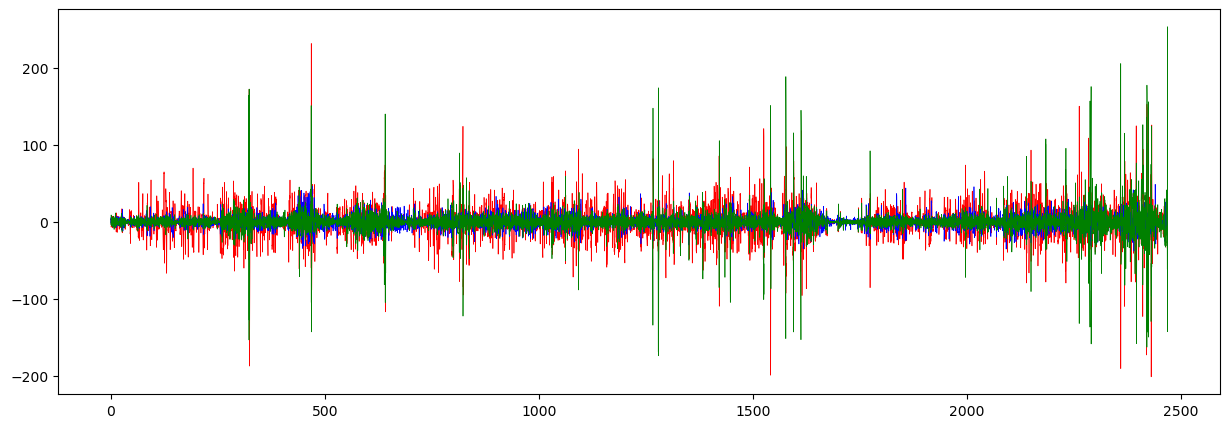

In [5]:
# Highpass filter to remove drift (assuming sampling rate of 100 Hz, and cutoff frequency of 0.1 Hz)
fs = 1000
fc1 = 0.2
fc2 = 50
y = signal_filter(y, fc1, fc2, fs)
p = signal_filter(p, fc1, fc2, fs)
r = signal_filter(r, fc1, fc2, fs)

plt.figure(figsize=(15, 5))
# plt.plot(timestamps, y, 'k--', lw=0.5)
# plt.plot(timestamps, p, 'b--', lw=0.5)
# plt.plot(timestamps, r, 'g--', lw=0.5)
plt.plot(timestamps, y, 'r', lw=0.5)
plt.plot(timestamps, p, 'b', lw=0.5)
plt.plot(timestamps, r, 'g', lw=0.5)


# plt.xlim(264, 300)

(560.0, 600.0)

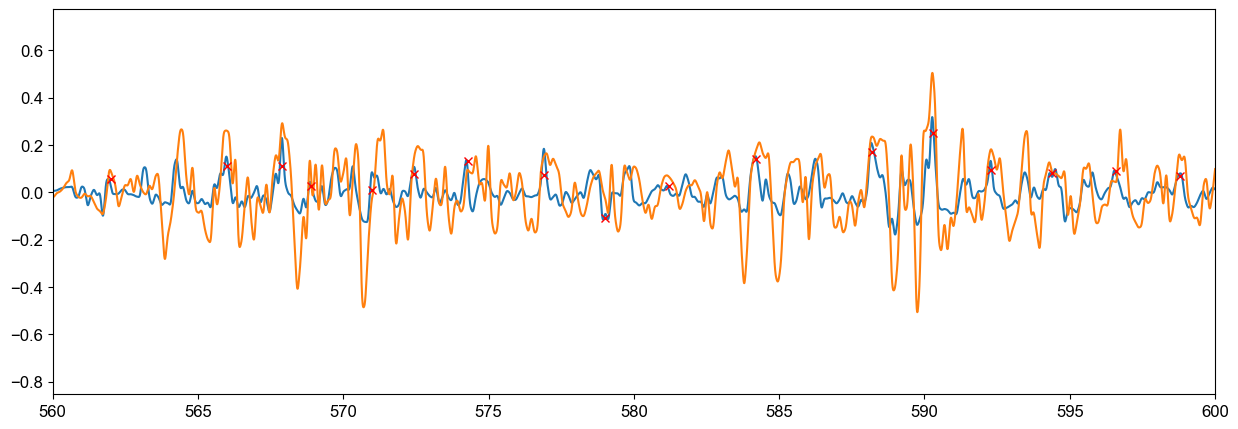

In [689]:
plt.figure(figsize=(15, 5))

events = pd.read_csv('../videos/basketball/data_points.csv', header=None).to_numpy().squeeze()
plt.plot(timestamps, c)
plt.plot(timestamps, b)
for event in events:
    plt.plot(event, c[np.where(np.abs(timestamps - event) <= 8e-2)[0][0]], 'rx')

plt.xlim(560, 600)

(71,)


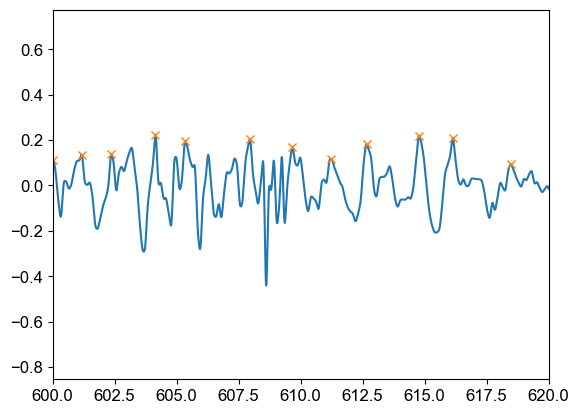

In [690]:
peaks, _ = find_peaks(b, distance=1000, height=0)

modified_events = []

for event in events:
    differences = np.abs(peaks - event * 1000)
    min_diff_index = np.argmin(differences)
    if differences[min_diff_index] <= 1000:
        modified_events.append(peaks[min_diff_index])

modified_events = np.array(modified_events)
plt.plot(timestamps, b)
plt.plot(timestamps[peaks], b[peaks], 'x')
plt.xlim(600, 620)

print(modified_events.shape)

(600.0, 620.0)

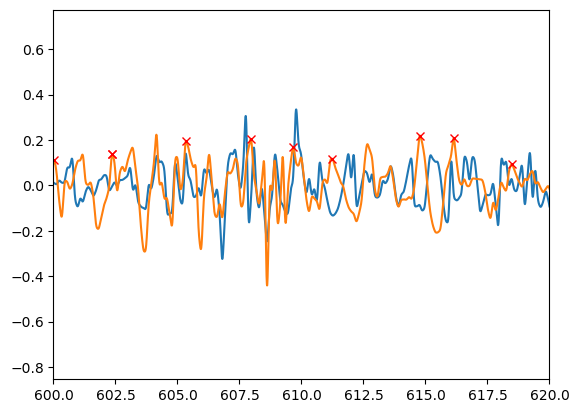

In [8]:
plt.plot(timestamps, c)
plt.plot(timestamps, b)
for event in modified_events:
    plt.plot(timestamps[event], b[event], 'rx')

plt.xlim(600, 620)

In [9]:
data1 = np.column_stack((c, b, tl, tr, y, p, r))
data1.shape

(2328701, 7)

In [10]:
# time period for each activity, [start_idx, end_idx]
jogging = [580000, 670000]
resting = [670000, 780000]
shooting = [780000, 1184000]
layup = [1184000, 1560000]

In [406]:
timestamps1 = timestamps * 0.001 / (timestamps[1] - timestamps[0])
events1 = modified_events * 0.001 / (timestamps[1] - timestamps[0])

In [12]:
def manual_find_peaks(activity, signal, height=None, distance=None):
    section_signal = signal[activity[0]:activity[1]]
    section_timestamps = timestamps1[activity[0]:activity[1]]
    idx, _ = find_peaks(section_signal, height=height, distance=distance)
    plt.plot(section_timestamps, section_signal)
    plt.plot(section_timestamps[idx], section_signal[idx], marker="o", ls="", ms=3)
    return section_timestamps[idx], idx

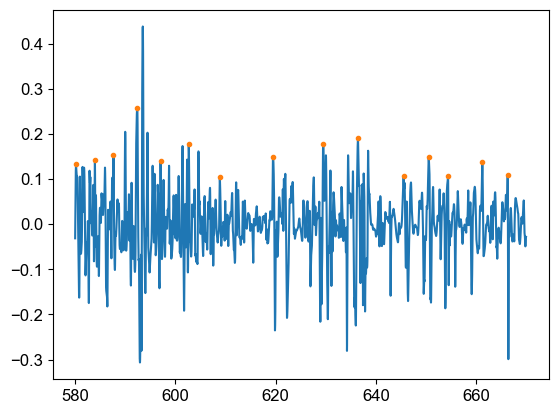

In [60]:
jogging_peak_time, jogging_peak = manual_find_peaks(jogging, c, height=(0.1, 0.3), distance=3000)

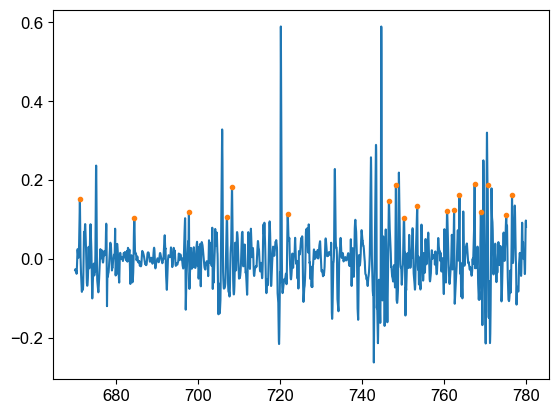

In [61]:
resting_peak_time, resting_peak = manual_find_peaks(resting, c, height=(0.1, 0.2), distance=1000)

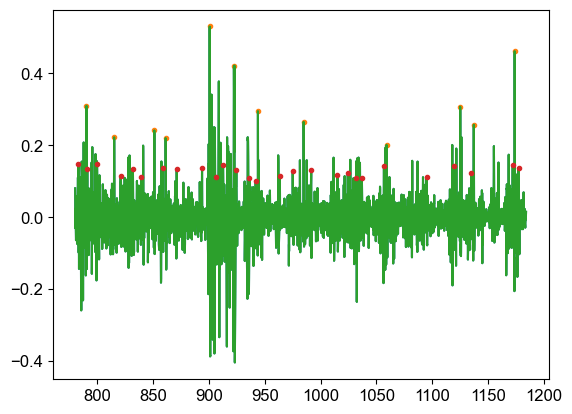

In [688]:
shooting_peak_time, shooting_peak = manual_find_peaks(shooting, c, height=0.2, distance=10000)
resting_peak_time_2, resting_peak_2 = manual_find_peaks(shooting, c, height=(0.1, 0.15), distance=5000)
# plt.xlim(800, 1000)

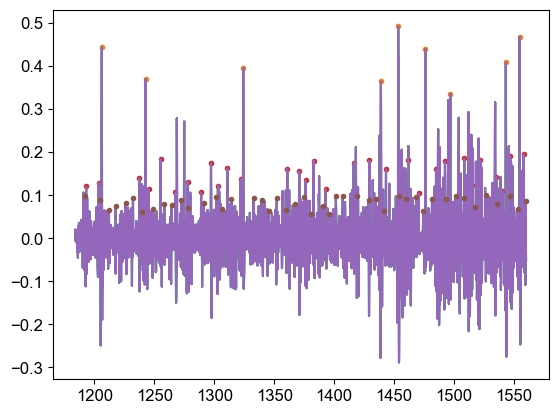

In [667]:
shooting_peak_time_2, shooting_peak_2 = manual_find_peaks(layup, c, height=0.3, distance=10000)
jogging_peak_time_2, jogging_peak_2 = manual_find_peaks(layup, c, height=(0.1, 0.2), distance=5000)
resting_peak_time_3, resting_peak_3 = manual_find_peaks(layup, c, height=(0.05, 0.1), distance=5000)

# plt.xlim(1200, 1225)

In [691]:
window_width = 3000

# num_events = len(modified_events)
# temp_container = np.zeros((num_events, window_width))

# for idx, event in enumerate(modified_events):
#     start = event - window_width // 2
#     end = event + window_width // 2
#     temp_container[idx, :] = b[start:end]

# avg = np.mean(temp_container, axis=0)
# std = np.std(temp_container, axis=0)

# mask = np.ones(len(temp_container), dtype=bool)

# for idx, sample in enumerate(temp_container):
#     if np.any(sample > avg + 3*std) or np.any(sample < avg - 3*std):
#         mask[idx] = False

# modified_events = modified_events[mask]
cough_peak_time = (modified_events / 1000).squeeze()
print(cough_peak_time.shape)

(71,)


In [692]:
peak_time = np.concatenate([cough_peak_time,
                            jogging_peak_time,
                            jogging_peak_time_2,
                            resting_peak_time,
                            resting_peak_time_2,
                            resting_peak_time_3,
                            shooting_peak_time,
                            shooting_peak_time_2])[:, np.newaxis]

# cough 1, shooting/resting 0, jogging/layup 2
peak_activities = np.array(([1] * cough_peak_time.size) + \
                           ([3] * jogging_peak_time.size) + \
                           ([3] * jogging_peak_time_2.size) + \
                           ([0] * resting_peak_time.size) + \
                           ([0] * resting_peak_time_2.size) + \
                           ([0] * resting_peak_time_3.size) + \
                           ([2] * shooting_peak_time.size) + \
                           ([2] * shooting_peak_time_2.size))[:, np.newaxis]
peak_time_activities = np.concatenate([peak_time, peak_activities], axis=1)
peak_time_activities = peak_time_activities[peak_time_activities[:, 0].argsort(), :]

peak_time_activities.shape

(230, 2)

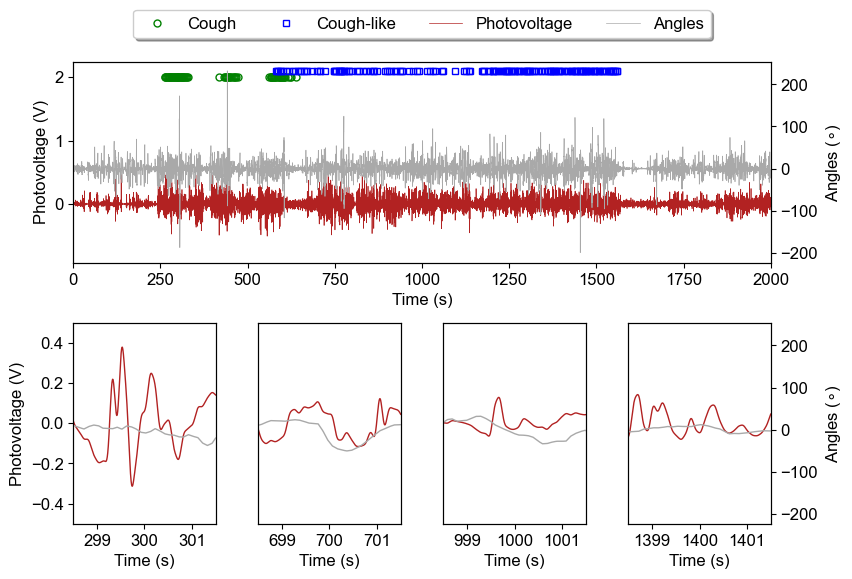

In [745]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 12

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(211)
plt.plot(peak_time_activities[peak_time_activities[:, 1] == 1][:, 0],
         2 * np.ones_like(peak_time_activities[peak_time_activities[:, 1] == 1][:, 0]),
         'o', mfc='None', mec='g', ms=5, label='Cough')
plt.plot(peak_time_activities[peak_time_activities[:, 1] != 1][:, 0],
         2.1 * np.ones_like(peak_time_activities[peak_time_activities[:, 1] != 1][:, 0]),
         's', mfc='None', mec='b', ms=5, label='Cough-like')
plt.plot(timestamps1, b, c='firebrick', lw=0.5, label='Photovoltage')
plt.xlim([0, 2000])
plt.xlabel('Time (s)')
plt.ylabel('Photovoltage (V)')
handles1, labels1 = ax.get_legend_handles_labels()
ax = ax.twinx()
plt.plot(timestamps1, y, c='darkgray', lw=0.5, label='Angles')
plt.ylabel('Angles ($\circ$)')

handles2, labels2 = ax.get_legend_handles_labels()

handles = handles1 + handles2
labels = labels1 + labels2

plt.legend(handles, labels, loc='upper center',
           bbox_to_anchor=(0.5, 1.3), ncols=4, fancybox=True, shadow=True)

ax = fig.add_subplot(245)
plt.plot(timestamps1, b, c='firebrick', lw=1)
plt.ylabel('Photovoltage (V)')
plt.ylim([-0.5, 0.5])
plt.xlabel('Time (s)')
ax = ax.twinx()
plt.yticks([])
plt.plot(timestamps1, y, c='darkgray', lw=1)
plt.xlim(298.5, 301.5)

ax = fig.add_subplot(246)
plt.yticks([])
plt.plot(timestamps1, b, c='firebrick', lw=1)
plt.ylim([-0.5, 0.5])
plt.xlabel('Time (s)')
ax = ax.twinx()
plt.yticks([])
plt.plot(timestamps1, y, c='darkgray', lw=1)
plt.xlim(698.5, 701.5)

ax = fig.add_subplot(247)
plt.yticks([])
plt.plot(timestamps1, b, c='firebrick', lw=1)
plt.ylim([-0.5, 0.5])
plt.xlabel('Time (s)')
ax = ax.twinx()
plt.yticks([])
plt.plot(timestamps1, y, c='darkgray', lw=1)
plt.xlim(998.5, 1001.5)

ax = fig.add_subplot(248)
plt.yticks([])
plt.plot(timestamps1, b, c='firebrick', lw=1)
plt.ylim([-0.5, 0.5])
plt.xlabel('Time (s)')
ax = ax.twinx()
plt.ylabel('Angles ($\circ$)')
plt.plot(timestamps1, y, c='darkgray', lw=1)
plt.xlim(1398.5, 1401.5)

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.savefig('basketball_long_test.png', dpi=600, bbox_inches='tight')
plt.show()

(230, 3000, 7)


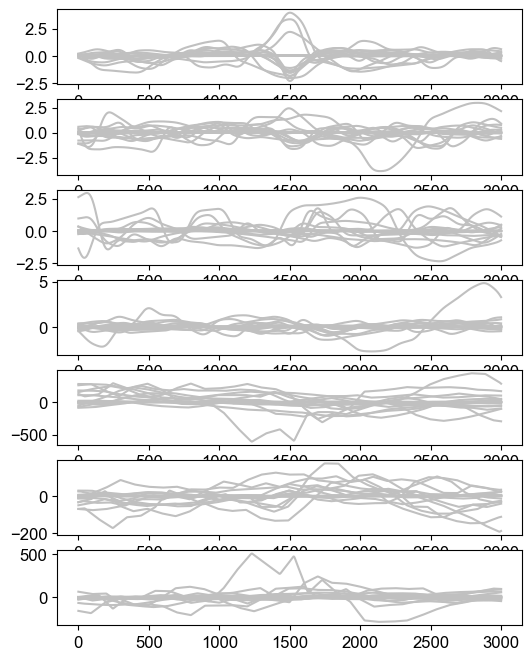

In [699]:
window_width = 3000
expanded_peaks = peak_expand((peak_time * 1000).squeeze().astype(int) - 1, window_width, len(timestamps1))

slices = []
for idx in range(expanded_peaks.shape[0]):
    if peak_time_activities[idx, 1] == 0:
        sample = data1[expanded_peaks[idx, :]]
        sample *= 0.1
        slices.append(sample)
    elif peak_time_activities[idx, 1] == 1:
        sample = data1[expanded_peaks[idx, :]]
        sample *= 2
        slices.append(sample)
    elif peak_time_activities[idx, 1] == 2:
        sample = data1[expanded_peaks[idx, :]]
        sample *= 10
        slices.append(sample)
    elif peak_time_activities[idx, 1] == 3:
        sample = data1[expanded_peaks[idx, :]]
        sample *= -5
        slices.append(sample)
slices = np.array(slices)

print(slices.shape)
# print((peak_time_activities[:, 1] == 1).sum())

fig, axes = plt.subplots(ncols=1, nrows=7, figsize=(6, 8))

for idx, slice in enumerate(slices):
    if peak_activities[idx] == 2:
        for ch, ax in enumerate(axes):
            ax.plot(slice[:, ch], c='silver')

# Training

In [77]:
import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader

# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(torch.__version__)
print(torch.__config__.show())
print(f'PyTorch is running on {device}')

2.0.0
PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90;-gencode;arch=compute_37,code=compute_37
  - CuDNN 8.7
  - Magma 2.5.4
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.8, CUDNN_VERSION=8.7.0, CXX_COMPILER=C:/cb/pytorch_1000000000000/work/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /

In [700]:
class BaseLHMDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

class LHMDualDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        photovoltage_data = self.features[idx, :4, :].float().transpose(0, 1)  # First 4 channels
        euler_angle_data = self.features[idx, 4:, :].float().transpose(0, 1)  # Last 3 channels
        return photovoltage_data, euler_angle_data, self.labels[idx]
    
features = torch.tensor(slices).permute(0, 2, 1).type(torch.LongTensor)
labels = peak_time_activities[:, 1]
labels = torch.tensor(labels).type(torch.LongTensor)

print(features.shape)
print(labels.shape)

dual_ds = LHMDualDataset(features, labels)
dual_ds.features.shape

torch.Size([230, 7, 3000])
torch.Size([230])


torch.Size([230, 7, 3000])

In [701]:
input_dim1 = 4 # For photovoltage data
input_dim2 = 3 # For Euler angle data

# for conv1d
kernel_size = 200
stride = 200
padding = 0

# for gru
hidden_dim = 256
layer_dim = 1
output_dim = len(np.unique(peak_activities.ravel())) # Number of classes
dropout_prob = 0

num_epochs = 100

# Preparing data
batch_size = 64

total_samples = len(dual_ds)
test_size = int(0.3 * total_samples)
train_size = total_samples - test_size

# create an indices tensor to keep track of the random_split
indices = torch.arange(total_samples)

generator = torch.Generator().manual_seed(114514)
train_indices, test_indices = random_split(indices, [train_size, test_size], generator=generator)
train_dataset_dual, test_dataset_dual = random_split(dual_ds, [train_size, test_size], generator=generator)

train_loader_dual = DataLoader(train_dataset_dual, batch_size=batch_size, shuffle=False)
test_loader_dual = DataLoader(test_dataset_dual, batch_size=batch_size, shuffle=False)
train_loader_indices = DataLoader(train_indices, batch_size=batch_size, shuffle=False)
test_loader_indices = DataLoader(test_indices, batch_size=batch_size, shuffle=False)

In [124]:
class DualGRUModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim

        # GRU layers
        self.gru1 = nn.GRU(input_dim1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.gru2 = nn.GRU(input_dim2, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        out1, _ = self.gru1(x1)
        out2, _ = self.gru2(x2)

        # Concatenate the outputs from both GRUs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out
    

class DualConvGRUModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, 
                 kernel_size, stride, padding,
                 hidden_dim, layer_dim, output_dim, dropout_prob):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim

        # Conv layers
        self.conv1_1 = nn.Conv1d(in_channels=input_dim1, out_channels=input_dim1,
                                 kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2_1 = nn.Conv1d(in_channels=input_dim2, out_channels=input_dim2,
                                 kernel_size=kernel_size, stride=stride, padding=padding)
        
        # Dropout
        self.dropout = nn.Dropout(p=dropout_prob)

        # GRU layers
        self.gru1 = nn.GRU(input_dim1, hidden_dim, layer_dim, batch_first=True)
        self.gru2 = nn.GRU(input_dim2, hidden_dim, layer_dim, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        x1 = x1.permute(0, 2, 1)
        x2 = x2.permute(0, 2, 1)

        x1 = self.conv1_1(x1)
        x2 = self.conv2_1(x2)

        x1 = self.dropout(x1)
        x2 = self.dropout(x2)

        x1 = x1.permute(0, 2, 1)
        x2 = x2.permute(0, 2, 1)
        # print(out1.shape)
        # print(out2.shape)

        out1, _ = self.gru1(x1)
        out2, _ = self.gru2(x2)

        # Concatenate the outputs from both GRUs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out

In [80]:
# Container for losses and accuracies
train_losses_gru_dual = []
train_accuracies_gru_dual = []

test_losses_gru_dual = []
test_accuracies_gru_dual = []

# Model definition
model_gru_dual = DualGRUModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
criterion = nn.CrossEntropyLoss()
optimizer_dual = torch.optim.Adam(model_gru_dual.parameters(), lr=0.0001, weight_decay=0.001)
print(model_gru_dual.to(device))

for epoch in range(num_epochs):
    model_gru_dual.train()  # Set the model to training mode
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0

    # temp_out_pack = torch.zeros((1, model_gru_dual.output_dim)).to(device)

    for photovoltage_data, euler_angle_data, labels in train_loader_dual:
        # Load data
        photovoltage_data = photovoltage_data.to(device)
        euler_angle_data = euler_angle_data.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_gru_dual(photovoltage_data, euler_angle_data)
        # temp_out_pack = torch.vstack((temp_out_pack, outputs))
        loss = criterion(outputs, labels.squeeze())

        # Backward pass and optimization
        optimizer_dual.zero_grad()
        loss.backward()
        optimizer_dual.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        total_train_correct += (predicted == labels.squeeze()).sum().item()

    avg_train_loss = total_train_loss / len(train_loader_dual)
    train_accuracy = total_train_correct / total_train_samples
    train_losses_gru_dual.append(avg_train_loss)
    train_accuracies_gru_dual.append(train_accuracy)

    model_gru_dual.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    total_test_correct = 0
    total_test_samples = 0

    with torch.no_grad():
        for photovoltage_data, euler_angle_data, labels in test_loader_dual:
            # Load data
            photovoltage_data = photovoltage_data.to(device).float()
            euler_angle_data = euler_angle_data.to(device).float()
            labels = labels.to(device)

            # Forward pass
            outputs = model_gru_dual(photovoltage_data, euler_angle_data)
            # temp_out_pack = torch.vstack((temp_out_pack, outputs))
            loss = criterion(outputs, labels.squeeze())

            total_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test_samples += labels.size(0)
            total_test_correct += (predicted == labels.squeeze()).sum().item()

    avg_test_loss = total_test_loss / len(test_loader_dual)
    test_accuracy = total_test_correct / total_test_samples
    test_losses_gru_dual.append(avg_test_loss)
    test_accuracies_gru_dual.append(test_accuracy)

    # Print training and testing statistics for each epoch
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
                f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


DualGRUModel(
  (gru1): GRU(4, 128, batch_first=True)
  (gru2): GRU(3, 128, batch_first=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/100], Train Loss: 1.3781, Train Accuracy: 0.2143, Test Loss: 1.3729, Test Accuracy: 0.1944
Epoch [10/100], Train Loss: 1.3377, Train Accuracy: 0.4881, Test Loss: 1.3487, Test Accuracy: 0.3333
Epoch [15/100], Train Loss: 1.3030, Train Accuracy: 0.4881, Test Loss: 1.3293, Test Accuracy: 0.3611
Epoch [20/100], Train Loss: 1.2718, Train Accuracy: 0.5000, Test Loss: 1.3130, Test Accuracy: 0.3889
Epoch [25/100], Train Loss: 1.2426, Train Accuracy: 0.5000, Test Loss: 1.2983, Test Accuracy: 0.3889
Epoch [30/100], Train Loss: 1.2144, Train Accuracy: 0.5595, Test Loss: 1.2846, Test Accuracy: 0.3611
Epoch [35/100], Train Loss: 1.1866, Train Accuracy: 0.5833, Test Loss: 1.2714, Test Accuracy: 0.3889
Epoch [40/100], Train Loss: 1.1587, Train Accuracy: 0.5714, Test Loss: 1.2589, Test Accuracy: 0.4167
Epoch [

In [702]:
# Model definition
model_cnngru_dual = DualConvGRUModel(input_dim1, input_dim2, 
                                     kernel_size, stride, padding,
                                     hidden_dim, layer_dim, output_dim, dropout_prob)
criterion = nn.CrossEntropyLoss()
optimizer_dual = torch.optim.Adam(model_cnngru_dual.parameters(), lr=0.0001, weight_decay=0.001)
print(model_cnngru_dual.to(device))

# Container for losses and accuracies
train_losses_cnngru_dual = []
train_accuracies_cnngru_dual = []
test_losses_cnngru_dual = []
test_accuracies_cnngru_dual = []

doLog = False

for epoch in range(num_epochs):
    model_cnngru_dual.train()  # Set the model to training mode
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0

    if (epoch + 1) % 20 == 0:
    # if epoch == 0:
        doLog = True

    for idx_in_batch, (photovoltage_data, euler_angle_data, labels) in zip(train_loader_indices, train_loader_dual):
        # Load data
        photovoltage_data = photovoltage_data.to(device)
        euler_angle_data = euler_angle_data.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_cnngru_dual(photovoltage_data, euler_angle_data)
        loss = criterion(outputs, labels.squeeze())

        # Backward pass and optimization
        optimizer_dual.zero_grad()
        loss.backward()
        optimizer_dual.step()

        # Calculate prediction
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        total_train_correct += (predicted == labels.squeeze()).sum().item()

    avg_train_loss = total_train_loss / len(train_loader_dual)
    train_accuracy = total_train_correct / total_train_samples
    train_losses_cnngru_dual.append(avg_train_loss)
    train_accuracies_cnngru_dual.append(train_accuracy)

    model_cnngru_dual.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    total_test_correct = 0
    total_test_samples = 0

    with torch.no_grad():
        for idx_in_batch, (photovoltage_data, euler_angle_data, labels) in zip(test_loader_indices, test_loader_dual):
            # Load data
            photovoltage_data = photovoltage_data.to(device).float()
            euler_angle_data = euler_angle_data.to(device).float()
            labels = labels.to(device)

            # Forward pass
            outputs = model_cnngru_dual(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            total_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test_samples += labels.size(0)
            total_test_correct += (predicted == labels.squeeze()).sum().item()

    avg_test_loss = total_test_loss / len(test_loader_dual)
    test_accuracy = total_test_correct / total_test_samples
    test_losses_cnngru_dual.append(avg_test_loss)
    test_accuracies_cnngru_dual.append(test_accuracy)

    # Print training and testing statistics for each epoch
    if doLog:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
        doLog = False


DualConvGRUModel(
  (conv1_1): Conv1d(4, 4, kernel_size=(200,), stride=(200,))
  (conv2_1): Conv1d(3, 3, kernel_size=(200,), stride=(200,))
  (dropout): Dropout(p=0, inplace=False)
  (gru1): GRU(4, 256, batch_first=True)
  (gru2): GRU(3, 256, batch_first=True)
  (fc): Linear(in_features=512, out_features=4, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [20/100], Train Loss: 1.0036, Train Accuracy: 0.8447, Test Loss: 1.1560, Test Accuracy: 0.7246
Epoch [40/100], Train Loss: 0.5062, Train Accuracy: 0.8758, Test Loss: 0.6755, Test Accuracy: 0.7826
Epoch [60/100], Train Loss: 0.2549, Train Accuracy: 0.9441, Test Loss: 0.3671, Test Accuracy: 0.8116
Epoch [80/100], Train Loss: 0.1479, Train Accuracy: 0.9752, Test Loss: 0.2654, Test Accuracy: 0.8551
Epoch [100/100], Train Loss: 0.0981, Train Accuracy: 0.9752, Test Loss: 0.2300, Test Accuracy: 0.8696


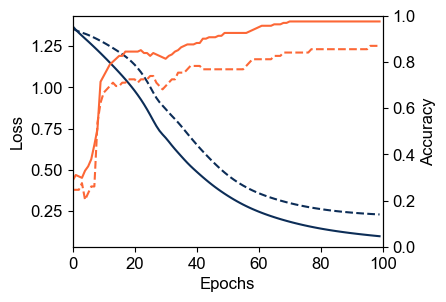

In [716]:
plt.figure(figsize=(4, 3))
ax1 = plt.subplot()
plt.plot(train_losses_cnngru_dual, color='#0C2D57')
plt.plot(test_losses_cnngru_dual, '--', color='#0C2D57')
ax1.set_xlim(0, 100)
# ax1.set_ylim(0.2, 0.8)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
plt.plot(train_accuracies_cnngru_dual, color='#FC6736')
plt.plot(test_accuracies_cnngru_dual, '--', color='#FC6736')
ax2.set_ylim(0, 1)
ax2.set_ylabel('Accuracy')

plt.savefig('training_curve.png', dpi=600, bbox_inches='tight')
plt.show()

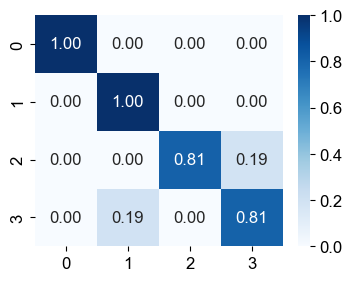

In [715]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []

model_cnngru_dual.eval()
data_loader = DataLoader(dual_ds, batch_size=1, shuffle=False)

with torch.no_grad():
    for pvs, angles, labels in data_loader:
        pvs = pvs.to(device).float()
        angles = angles.to(device).float()
        labels = labels.to(device)
        outputs = model_cnngru_dual(pvs, angles)
        outputs = torch.argmax(outputs, dim=1).cpu().numpy()

        y_pred.extend(outputs)
        y_true.extend(labels.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
cm_sum = np.repeat(np.sum(cm, axis=1)[:, np.newaxis], 4, axis=1)

plt.figure(figsize=(4, 3))
sns.heatmap(cm / cm_sum, annot=True, cmap='Blues', fmt='.2f')
plt.savefig('confusion_matrix.png', dpi=600, bbox_inches='tight')
plt.show()

In [709]:
y_pred = []
y_true = []
probabilities = []

model_cnngru_dual.eval()
data_loader = DataLoader(dual_ds, batch_size=1, shuffle=False)

with torch.no_grad():
    for pvs, angles, labels in data_loader:
        pvs = pvs.to(device).float()
        angles = angles.to(device).float()
        labels = labels.to(device)
        outputs = model_cnngru_dual(pvs, angles)

        exp_outputs = torch.exp(outputs).cpu()
        outputs = torch.argmax(outputs, dim=1).cpu().numpy()

        y_pred.extend(outputs)
        y_true.extend(labels.cpu().numpy())
        probabilities.append(exp_outputs)

probabilities = torch.cat(probabilities).numpy()

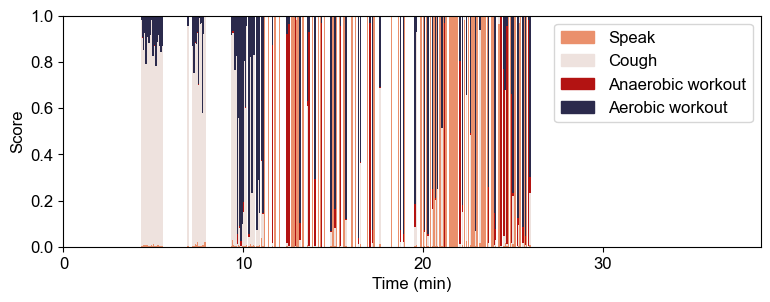

In [744]:
import matplotlib.patches as mpatches

colors = ['#EA906C', '#EEE2DE', '#B31312', '#2B2A4C']
labels = ['Speak', 'Cough', 'Anaerobic workout', 'Aerobic workout']

x = peak_time.squeeze()
bottom = np.zeros_like(x)

fig, ax = plt.subplots(figsize=(9, 3))
for idx in range(model_cnngru_dual.output_dim):
    ax.bar(x, probabilities[:, idx], 5, bottom=bottom, color=colors[idx])
    bottom += probabilities[:, idx]
# ax.plot(dual_ds.labels / len(dual_ds.labels), 'x')

patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]
ax.legend(handles=patches, loc='upper right')

xticks = np.arange(0, 2400, 600)

plt.xticks(xticks, labels=(xticks / 60).astype(int))
plt.xlim(0, timestamps1[-1])
plt.xlabel('Time (min)')

plt.ylabel('Score')
plt.ylim(0, 1)

plt.savefig('time_related_score.png', dpi=600, bbox_inches='tight')
plt.show()